# Data Exploration
---

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import json
import folium
from folium import plugins

import warnings
warnings.filterwarnings('ignore')

In [2]:
unique_df = pd.read_csv("../data/unique_austin_shelter.csv")

In [3]:
unique_df.set_index("animal_id", inplace=True)

# Where are dogs most frequently found?

In [4]:
coordinates = []
with open('../data/geocodes.txt') as f:
    for line in f:
        coordinates.append(json.loads(line))

In [5]:
coords = pd.DataFrame(coordinates)
coords['lat'] = coords.lat.astype(float)
coords['lng'] = coords.lng.astype(float)


In [6]:
m = folium.Map([30.2672, -97.7431], zoom_start=11)
for index, row in coords.iterrows():
    folium.CircleMarker([row['lat'], row['lng']],
                        radius=15,
                        fill_color="#3db7e4",
                       ).add_to(m)

In [7]:
m = folium.Map([30.2672, -97.7431], zoom_start=11)
coordArr = coords[['lat', 'lng']].as_matrix()
m.add_children(plugins.HeatMap(coordArr, radius=12))
m

### Answer:

From this map, we concluded that there is no specific area where dogs are found. However, we noticed that most dogs were found in neighborhood and parks (not including other animal shelters or animal hospitals).

## What is the average time a dog spends in the shelter?

In [8]:
(unique_df.date_out.apply(pd.to_datetime) - unique_df.date_in.apply(pd.to_datetime)).mean()

Timedelta('15 days 12:15:35.787856')

In [9]:
(unique_df.date_out.apply(pd.to_datetime) - unique_df.date_in.apply(pd.to_datetime)).max()

Timedelta('1026 days 21:15:00')

In [10]:
(unique_df.date_out.apply(pd.to_datetime) - unique_df.date_in.apply(pd.to_datetime)).min()

Timedelta('0 days 00:01:00')

### Answer:
The average time dogs spend in the shelter is 15 days. The most amount of time a dog has spent in the shelter was 2.8 years. The least amount of time a dog has spent in the shelter was 1 minute.

## What is the most common abandoned dog name?

In [11]:
unique_df.name.value_counts().head()

Bella    271
Max      258
Daisy    204
Luna     193
Rocky    187
Name: name, dtype: int64

### Answer: 
Bella and Max are the most common names.

## How many dogs don't have names?

In [12]:
unique_df.name.isnull().value_counts()

False    31913
True      8219
Name: name, dtype: int64

### Answer:
8219 dogs out of 40132 are nameless.

## What is total number of dogs per outcome type?

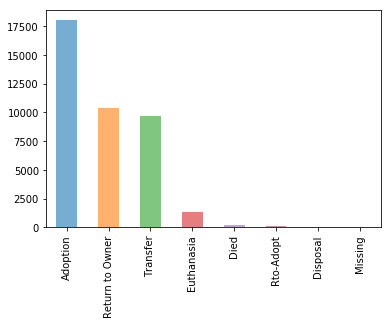

In [13]:
unique_df.outcome_type.value_counts().plot.bar(alpha=0.6)

In [14]:
unique_df.outcome_type.value_counts()

Adoption           18003
Return to Owner    10347
Transfer            9650
Euthanasia          1349
Died                 169
Rto-Adopt            165
Disposal              12
Missing               12
Name: outcome_type, dtype: int64

### Answer:
See list above. 

## Does intake conditon affect outcome?

In [15]:
intake_counts = pd.crosstab(unique_df.intake_condition, unique_df.outcome_type)
intake_counts_df = intake_counts / intake_counts.sum()
intake_counts_df

outcome_type,Adoption,Died,Disposal,Euthanasia,Missing,Return to Owner,Rto-Adopt,Transfer
intake_condition,,,,,,,,
Aged,0.002666,0.023669,0.00,0.038547,0.000000,0.010631,0.006061,0.004560
Feral,0.000111,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000622
Injured,0.031995,0.224852,0.25,0.243143,0.083333,0.032280,0.060606,0.053368
Normal,0.937566,0.455621,0.50,0.564122,0.750000,0.945105,0.909091,0.859482
Nursing,0.013775,0.106509,0.00,0.005189,0.083333,0.002899,0.000000,0.024560
Other,0.001666,0.000000,0.00,0.007413,0.000000,0.001933,0.000000,0.003731
Pregnant,0.000667,0.000000,0.00,0.000000,0.000000,0.000290,0.000000,0.001762
Sick,0.011554,0.189349,0.25,0.141586,0.083333,0.006862,0.024242,0.051917


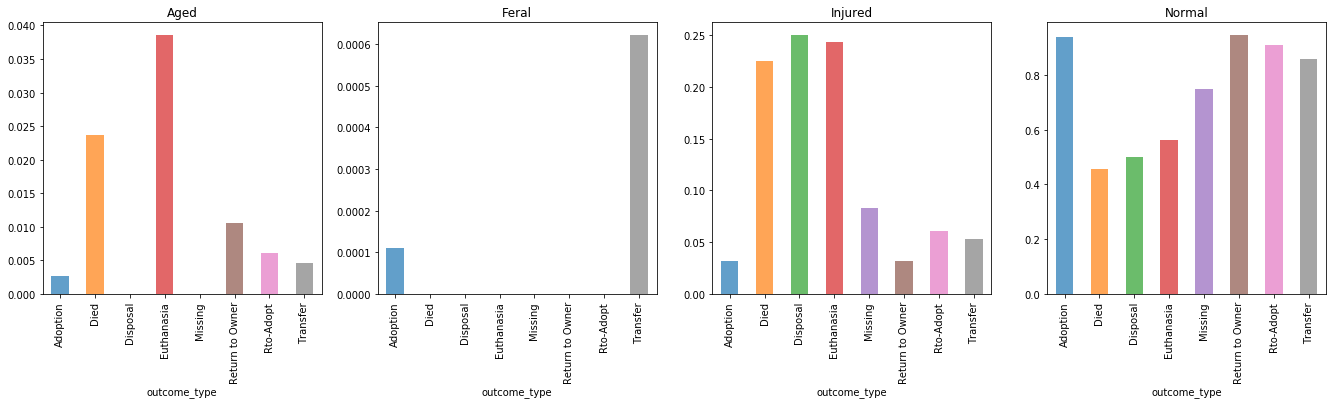

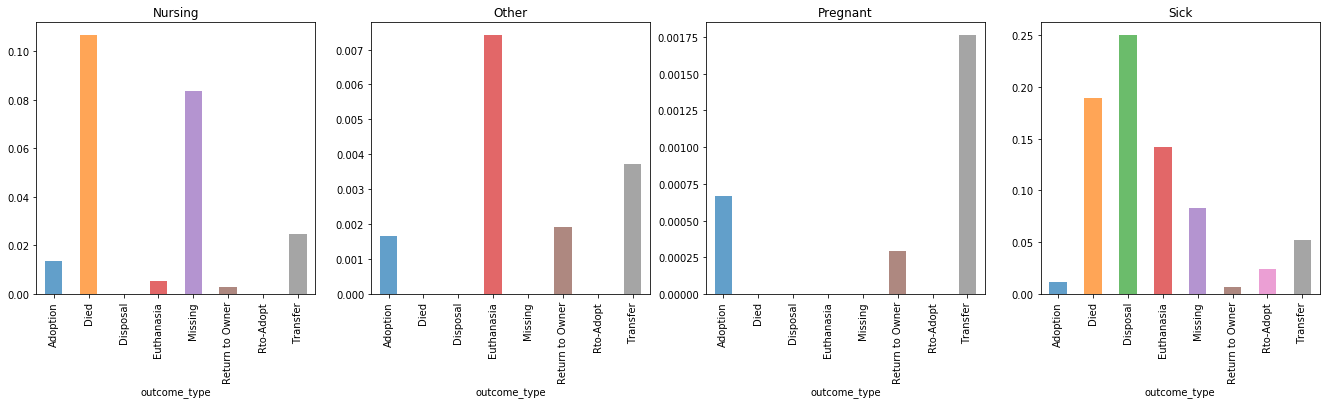

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(23, 5))

intake_cnds = intake_counts_df.index.unique()[:4]
for ax, intake_cnd in zip(axes, intake_cnds):
    intake_counts_df.loc[intake_cnd].plot.bar(alpha=0.7, ax=ax)
    ax.set_title(intake_cnd)
    
    
fig, axes = plt.subplots(1, 4, figsize=(23, 5))

intake_cnds = intake_counts_df.index.unique()[4:]
for ax, intake_cnd in zip(axes, intake_cnds):
    intake_counts_df.loc[intake_cnd].plot.bar(alpha=0.7, ax=ax)
    ax.set_title(intake_cnd)

### Answer (most common outcome):
* Aged: Euthanasia
* Feral: Tranfer
* Injured: Disposed
* Normal: Adopted or Returned to Owner
* Nursing: Died
* Other: Euthanasia
* Pregnant: Transfer
* Sick: Disposed

## Are injured or sick dogs more likely to be euthanized than healthy dogs?

In [17]:
euth_counts = pd.crosstab(unique_df.intake_condition,(unique_df.outcome_type=="Euthanasia"))
euth_counts

outcome_type,False,True
intake_condition,,
Aged,208,52
Feral,8,0
Injured,1507,328
Normal,35561,761
Nursing,555,7
Other,86,10
Pregnant,34,0
Sick,824,191


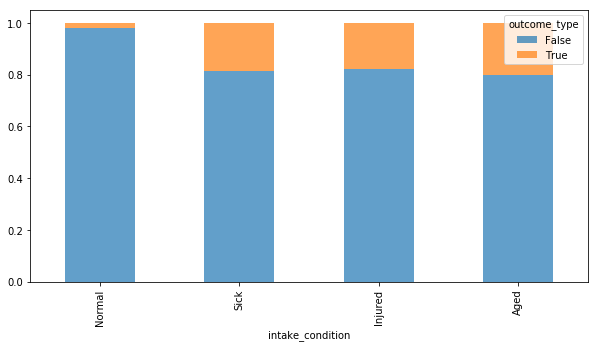

In [18]:
euth_counts_sum = euth_counts.sum(axis=1)
euth_given_intake = euth_counts.divide(euth_counts_sum, axis=0)
euth_given_intake.loc[['Normal', 'Sick', "Injured", "Aged"]].plot.bar(stacked=True, alpha=0.7, figsize=(10,5))

### Answer:
Injured, sick and aged dogs are euthanized more than normal dogs.

## Which intake condition results in the most adoptions?

In [19]:
adoption_counts = pd.crosstab(unique_df.intake_condition,(unique_df.outcome_type=="Adoption"))
adoption_counts

outcome_type,False,True
intake_condition,,
Aged,212,48
Feral,6,2
Injured,1259,576
Normal,19443,16879
Nursing,314,248
Other,66,30
Pregnant,22,12
Sick,807,208


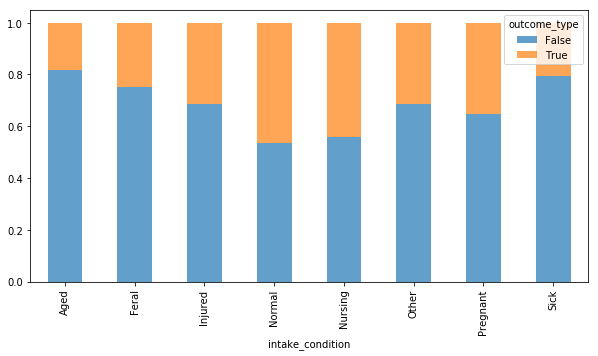

In [20]:
adopt_counts_sum = adoption_counts.sum(axis=1)
adopt_given_intake = adoption_counts.divide(adopt_counts_sum, axis=0)
adopt_given_intake.plot.bar(stacked=True, alpha=0.7, figsize=(10,5))

### Answer:
The most adopted dogs are normal, followed by nursing and pregnant dogs.

## Does the outcome of a dog change based on gender?

In [21]:
sex_counts = pd.crosstab(unique_df.outcome_type, unique_df.sex)
sex_counts

sex,Female,Male
outcome_type,,
Adoption,8863,9139
Died,76,77
Disposal,4,6
Euthanasia,567,749
Missing,6,6
Return to Owner,4385,5920
Rto-Adopt,67,98
Transfer,4634,4908


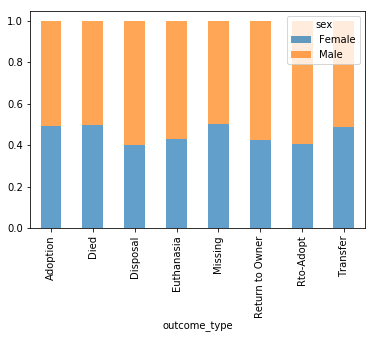

In [22]:
sex_counts_sum = sex_counts.sum(axis=1)
outcome_given_sex = sex_counts.divide(sex_counts_sum, axis=0)
outcome_given_sex.plot.bar(stacked=True, alpha=0.7)

### Answer:
Male dogs are more likely to be disposed of, Euthanized, Returned to Owner, and Rto-Adopted. Male and female dogs are equally likely to be adopted, to die, to go missing and to be transfered.

## What are the top 20 abandoned dog breeds?

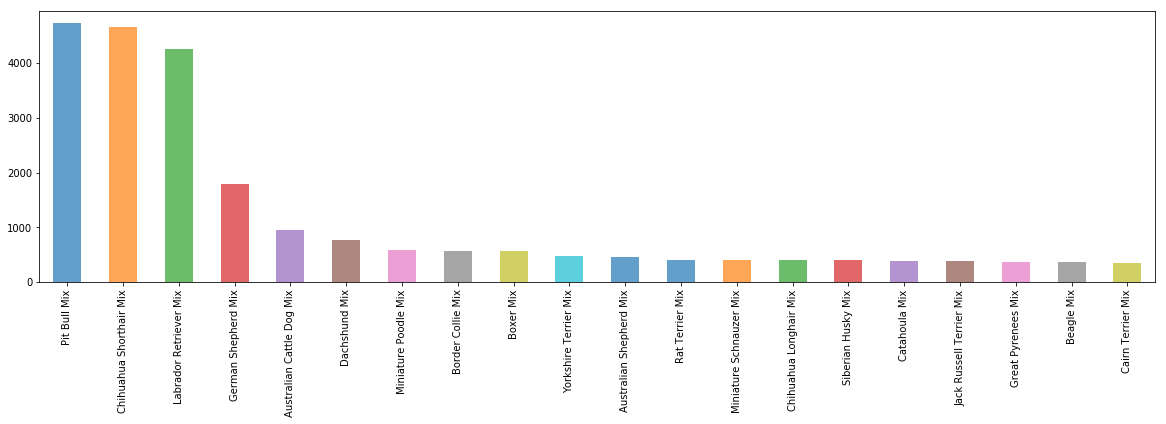

In [23]:
unique_df.breed.value_counts()[:20].plot.bar(figsize=(20,5), alpha=0.7)

### Answer:
Pitbull Mixes are abandoned the most.

## What are the top 20 adopted dog breeds?

In [24]:
unique_df.loc[(unique_df.in_shelter == "No") 
              & (unique_df.outcome_type=="Adoption")].breed.value_counts()[:10]

Chihuahua Shorthair Mix      2152
Labrador Retriever Mix       2138
Pit Bull Mix                 1728
German Shepherd Mix           863
Australian Cattle Dog Mix     512
Dachshund Mix                 361
Border Collie Mix             317
Boxer Mix                     244
Miniature Poodle Mix          237
Australian Shepherd Mix       225
Name: breed, dtype: int64

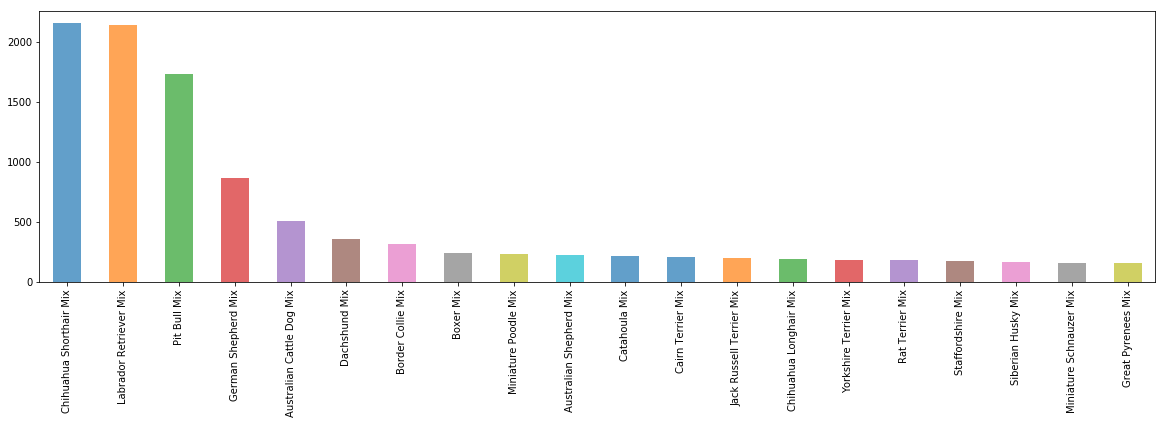

In [25]:
(unique_df.loc[(unique_df.in_shelter == "No") & (unique_df.outcome_type=="Adoption")]
                 .breed.value_counts()[:20].plot.bar(figsize=(20,5), alpha=0.7))

### Answer:
Chihuahua Shorthair Mixes are adopted the most.

## What is the most common time of the year a dog is admitted?

In [26]:
unique_df.date_in = unique_df.date_in.apply(pd.to_datetime)

In [27]:
months = [1,2,3,4,5,6,7,8,9,10,11,12]
years = [2014,2015,2016,2017,2018]

In [28]:
admission_by_month = pd.DataFrame(index=months , columns=years)

In [29]:
for year in years:
    for month in months:
        temp = unique_df.date_in.apply(lambda x: (x.month==month) & (x.year==year)).value_counts()
        admission_by_month.loc[month,year] = temp[1]

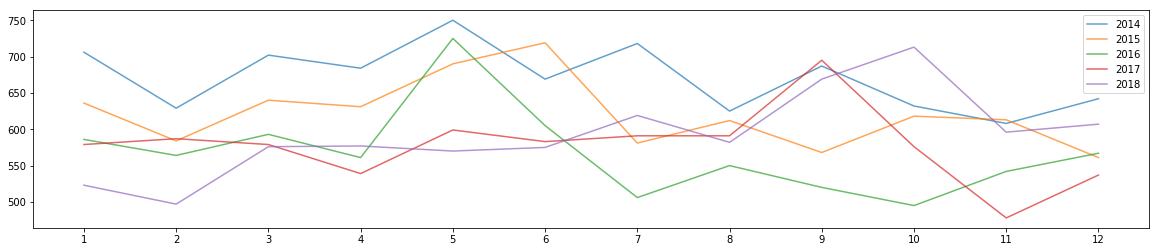

In [30]:
admission_by_month.plot.line(xticks=months, figsize=(20,4),alpha=0.7)

### Answer:
* In 2018, the most amount of dogs were admitted in October, and the least amount of dogs were admitted in February.
* In 2017, the most amount of dogs were admitted in September, and the least amount of dogs were admitted in November.
* In 2016, the most amount of dogs were admitted in May, and the least amount of dogs were admitted in October.
* In 2015, the most amount of dogs were admitted in June, and the least amount of dogs were admitted in December.
* In 2014, the most amount of dogs were admitted in May, and the least amount of dogs were admitted in February.
* Overall, there is no pattern.

## What is the most common time a dog is adopted?

In [31]:
unique_df.date_out = unique_df.date_out.apply(pd.to_datetime)

In [32]:
months = [1,2,3,4,5,6,7,8,9,10,11,12]
years = [2014,2015,2016,2017,2018]

In [33]:
adoption_by_month = pd.DataFrame(index=months , columns=years)

In [34]:
for year in years:
    for month in months:
        
        temp = unique_df[unique_df.outcome_type=="Adoption"].date_in.apply(lambda x: (x.month==month) & (x.year==year)).value_counts()
        
        adoption_by_month.loc[month,year] = temp[1]

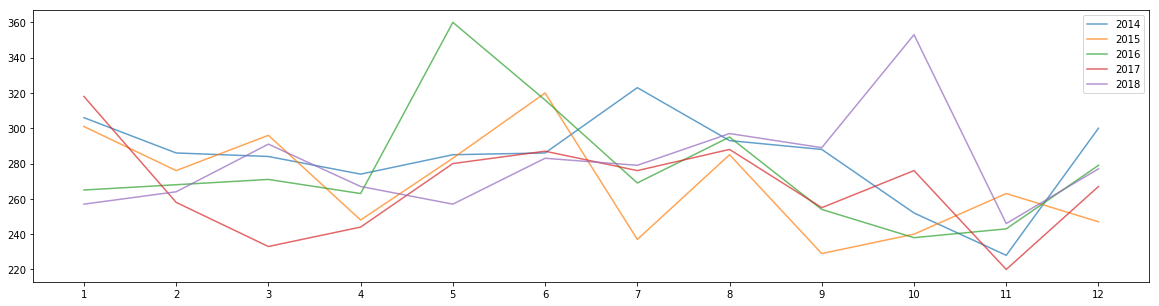

In [35]:
adoption_by_month.plot.line(xticks=months, figsize=(20,5),alpha=0.7)

### Answer:
* In 2018, the most amount of dogs were adopted in October, and the least amount of dogs were adopted in November.
* In 2017, the most amount of dogs were adopted in August, and the least amount of dogs were adopted in November.
* In 2016, the most amount of dogs were adopted in May, and the least amount of dogs were adopted in October.
* In 2015, the most amount of dogs were adopted in June, and the least amount of dogs were adopted in September.
* In 2014, the most amount of dogs were adopted in July, and the least amount of dogs were adopted in November.
* Overall, less dogs are not adopted in November. 

## What is the most common age a dog is admitted?

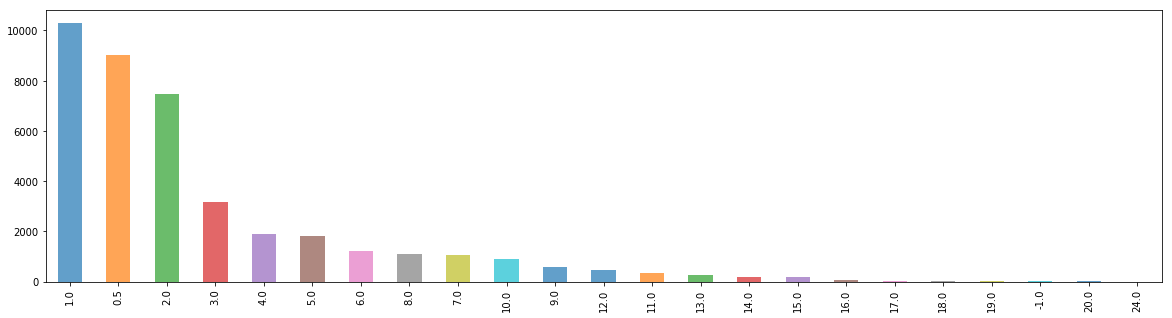

In [36]:
unique_df.age_in.apply(round).replace(0, 0.5).value_counts().plot.bar(figsize=(20,5),alpha=0.7)

### Answer:
The most common age that dogs are admitted is 1 or younger.

## What is the most common age a dog is adopted?

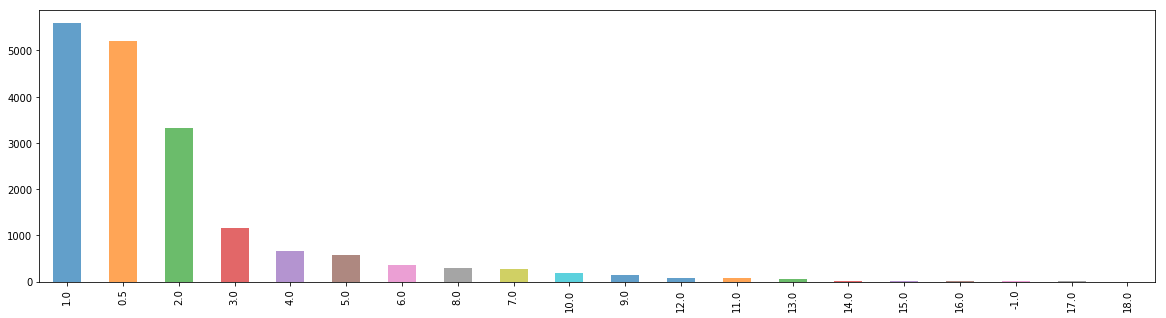

In [37]:
unique_df.loc[unique_df.outcome_type ==
              "Adoption"]['age_out'].apply(round).replace(0, 0.5).value_counts().plot.bar(figsize=(20,5),alpha=0.7)

### Answer:
The most common age that dogs are adopted is 1 or younger.

## What is the best age to abandon your dog to ensure that it will be adopted?

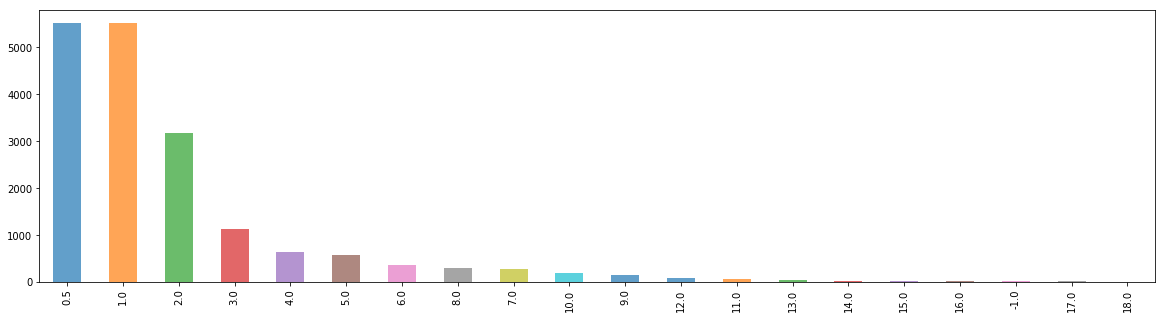

In [38]:
unique_df.loc[unique_df.outcome_type == "Adoption"]['age_in'].apply(round).replace(0, 0.5).value_counts().plot.bar(figsize=(20,5),alpha=0.7)

### Answer:
The most common age that you should abandon your dog to ensure that it will be adopted is as young as possible.

## How many surrendered dogs were returned to their owners?

In [39]:
returned_dogs = ((unique_df.intake_type=="Owner Surrender")
                 &(unique_df.outcome_type=="Return to Owner"))

returned_dogs.value_counts()

False    39739
True       393
dtype: int64

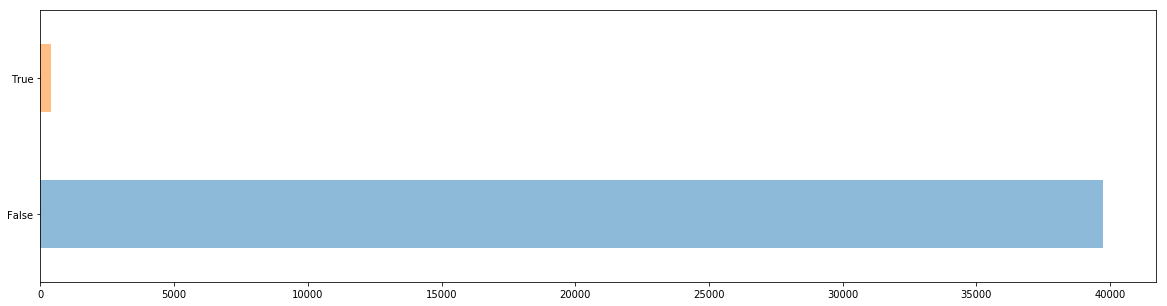

In [40]:
returned_dogs.value_counts().plot.barh(alpha=0.5,figsize=(20,5))

### Answer: 
Few dogs (0.98%) were returned to their owner. 

## What are the longest and shortest amounts of time that a dog was surrendered and then returned to its owner?

In [41]:
unique_df[returned_dogs].time_in_shelter.max()

'98 days 03:32:00.000000000'

In [42]:
unique_df[returned_dogs].time_in_shelter.min()

'0 days 00:09:00.000000000'

### Answer:
The longest amount of time a dog that was surrendered and then returned to its owner was 98 days. The shortest was 9 minutes.

## What is the most common way a dog is brought into a shelter?

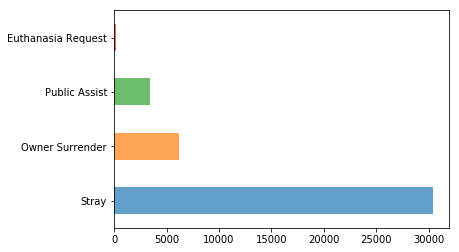

In [43]:
unique_df.intake_type.value_counts().plot.barh(alpha=0.7)

### Answer:
The most common way a dog is brought into the shelter is from the streets.

---